---
title: Order statistics — Part 2
date: 2021-03-07
categories: [statistics, order statistics]
tags: [statistics, order statistics, uniform distribution, general formula]
---

## 1. Introduction

In the [last post](https://enrightward.github.io/enrightward.github.io/posts/order-statistics-part-1/), we defined the _order statistics_ of a collection of iid random variables $X_{1}, \ldots, X_{n}$, to try and answer questions like "What's the expected value of $\max( \{ X_{1}, \ldots, X_{n} \} )$?", or more generally "what is $\mathbb{E}[(X_{(k)})]$?", where $X_{(k)}$ is defined by the property:

\begin{equation}
X_{(1)} \le X_{(2)} \le \ldots \le X_{(n)}.
\end{equation}

We investigated, in the special case where $X_{i} \sim U(0, 1)$, the values of $\mathbb{E}[(X_{(k)})]$ for $1 \le n \le 9$ and $1 \le k \le n$. By writing simple code to compute sample statistics, we conjectured that

\begin{equation}
\mathbb{E}[(X_{(k)})] = \frac{k}{n+1} \cdot
\end{equation}

We also proved this conjecture mathematically for $n = 1, 2$, in part using a 2D scatter plot understand the CDF $F$ in the two-variable case, then passing to the PDF $f$ by using the [Fundamental Theorem of Calculus](https://en.wikipedia.org/wiki/Fundamental_theorem_of_calculus). By the end of this post, we will generalise these results, deriving a formula for $\mathbb{E}[(X_{(k)})]$ for any $n$ and for all $1 \le k \le n$, for arbitrary common PDF $f$ of the $X_{i}$. This general formula will not be a closed formula — it will be an integral over a summation — but it will depend only on $n$, the PDF $f$ and the CDF $F$. In the special case where the $X_{i}$ are uniformly distributed on the unit interval, it will allow us to recover the formula $\mathbb{E}[(X_{(k)})] = \frac{k}{n+1}$. However, we will wait to the next post to recover this formula.

Before attacking the general proof, however, we will examine one last special case using code: Suppose we have three variables $X_{1}, X_{2}$ and $X_{3}$ all $\sim U(0, 1)$.

In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def sample_uniform(n, m):
    """Sample an `n`-tuple `m` times from the 
    uniform distribution on the unit interval"""
    return [np.random.random(n) for _ in range(m)]

def order_filter_3d(samples, k, limit):
    """Given a 3-dimensional, 3 x N numpy array `samples`, an integer 
    `k` in {0, 1, 2, 3} and a real number `limit` in [0, 1], returns the 
    3 x M subarray of `samples` for which each column vector has exactly 
    `k` entries <= `limit`."""
    # `k` must be an integer in {0, 1, 2}.
    assert k >= 0 and k <= 3
    filtered_samples = []
    
    # sample is a 3 x N array => sample.transpose() is 
    # N X 3, so its elements are 3D.
    for sample in samples.transpose():
        x, y, z = sample
        # how many of {x, y, z} are <= `limit`?
        num_lte_limit = sum([x <= limit, y <= limit, z <= limit])

        # if this number equals `k`, add the sample
        if num_lte_limit == k:
            filtered_samples.append([x, y, z])
    
    return np.array(filtered_samples)

def set_ax_values(ax, limit):
    """Helper function to label `ax`."""
    ax.set_xlabel('X_1')
    ax.set_ylabel('X_2')
    ax.set_zlabel('X_3')
    plt.title('Regions where X_(k) < {}, colour-coded by k in [0, 1, 2, 3]'.format(limit))

def plot_3d(region_samples, dotwidth, limit, theta, phi):
    """Given a list `region_samples` of 3 x N numpy arrays living 
    in [0, 1] x [0, 1] x [0, 1], plot the 3D points in each array with a 
    separate colour scheme. Each point has thickness `dotwidth` 
    and `limit` is used only to label the graph."""
    fig, ax = plt.subplots(figsize=(12, 10))
    ax = plt.axes(projection='3d')
    ax.view_init(theta, phi)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_zlim([0.0, 1.0])
    set_ax_values(ax, limit)
    cmaps = ['magma', 'viridis', 'winter']
    
    # display each region_sample in `region_samples`
    # on the same axis, but with a separate colour scheme.
    for i, region_sample in enumerate(region_samples):
        xs = region_sample[:, 0]
        ys = region_sample[:, 1]
        zs = region_sample[:, 2]
        cmap = cmaps[i % len(cmaps)]
        ax.scatter(xs, ys, zs, c=xs+ys+zs, cmap=cmap, linewidth=dotwidth, alpha=0.5)
    
    plt.show()

## 2. Visualising $\mathbb{Pr}(X_{(k)} \le x)$ in three dimensions

As in the previous post, let's use the above code to visualise the regions where $X_{(k)} \le x$, for $k = 1, 2, 3$. The volumes of these regions will be the probabilities $\mathbb{Pr}(X_{(k)} \le x)$. 

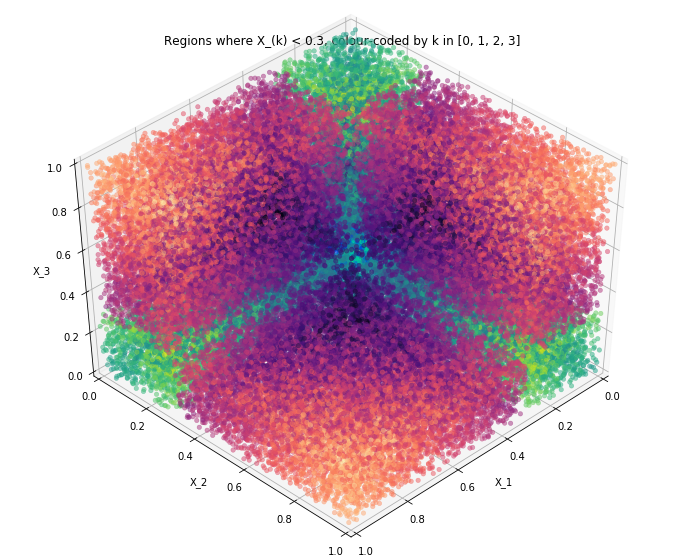

In [2]:
# sample 100,000 points to cover the unit square
num = int(1e5)
dotwidth = 0.5
samples = np.random.random((3, num))

# we're interested in which points have zero, one 
# two, or three coordinates <= 0.3
limit = 0.3
#ks = [0, 1, 2, 3]
ks = [1, 2, 3]
region_samples = []

# For each k in [0, 1, 2, 3], filter for the the 3D columns in 
# `samples` having exactly `k` coordinates <= 0.3.
for k in ks:
    filtered_samples = order_filter_3d(samples, k, limit)
    region_samples.append(filtered_samples)

theta = 45
phi = 45
plot_3d(region_samples, dotwidth, limit, theta, phi)

Let's show the same plot, but looking back from the opposite side of the far corner:

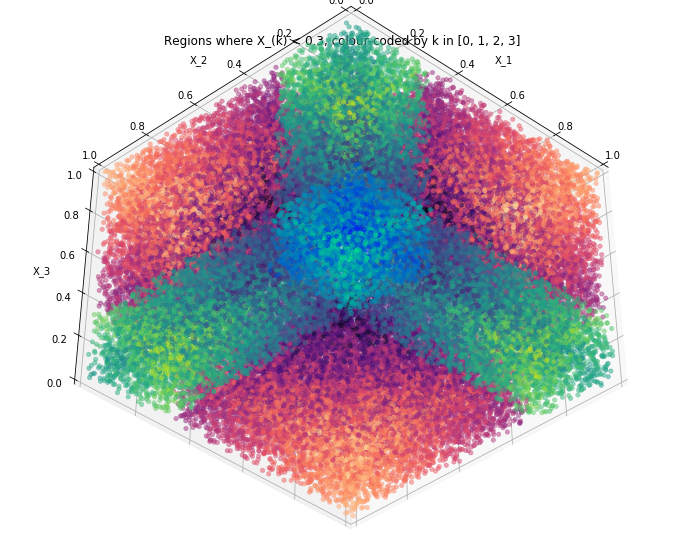

In [3]:
theta = -45
phi = 225
plot_3d(region_samples, dotwidth, limit, theta, phi)

## 3. Analysing the visulation: Computing CDFs

In the scatter plot above, we uniformly sampled 100,000 points $P = (x_{1}, x_{2}, x_{3})$ from the unit cube, and coloured them according to whether none, only one, two or all three of the coordinates $x_{i}$ were less than the (arbitrarily-chosen) cutoff value $x = 0.3$. The regions defined by these colours define all the ways these inequality conditions can be satisfied, and so their volumes are the probabilites these conditions hold, for $P$ randomly sampled. Specifically:

1. The <span style="color:cyan">blue cube region $R_{3}(x)$</span> ("the fattened origin") in the back corner is defined by the condition: 
\begin{equation}
R_{3}(x) := \{ (x_{1}, x_{2}, x_{3}) \in \mathbb{R}^{3} \mid x_{1}, x_{2}, x_{3} \le x \},
\end{equation}
so it follows
\begin{equation}
\mathbb{Pr}(X_{(1)}, X_{(2)}, X_{(3)} \le x) = 
\mathbb{Pr}(X_{1}, X_{2}, X_{3} \le x) = \textrm{vol}(R_{3}(x)) = x^{3}.
\end{equation}
2. The <span style="color:green">three green rectangular prisms</span> (the "fattened axes") are defined by the conditions:
\begin{align}
R_{2}^{1}(x) &:= \{ (x_{1}, x_{2}, x_{3}) \in \mathbb{R}^{3} \mid x_{2}, x_{3} \le x \le x_{1} \}, \newline
R_{2}^{2}(x) &:= \{ (x_{1}, x_{2}, x_{3}) \in \mathbb{R}^{3} \mid x_{1}, x_{3} \le x \le x_{2} \}, \newline
R_{2}^{3}(x) &:= \{ (x_{1}, x_{2}, x_{3}) \in \mathbb{R}^{3} \mid x_{1}, x_{2} \le x \le x_{3} \}.
\end{align}
The union $R_{2}(x)$ of these three sets is:
\begin{align}
R_{2}(x) := \{ (x_{1}, x_{2}, x_{3}) \in \mathbb{R}^{3} \mid x_{i}, x_{j} \le x \le x_{k} 
\textrm{ for } 1 \le i, j, k \le 3 \}.
\end{align}
For any of the $R_{2}^{i}(x)$, two of the three coordinates are confined to an $x \times x$ square, and the last one takes values between $x$ and $1$. So, $\textrm{vol}(R_{2}^{i}(x)) = x^{2}(1-x)$, implying that 
\begin{align}
\mathbb{Pr}(X_{(1)}, X_{(2)} \le x \le X_{(3)}) = \textrm{vol}(R_{2}(x)) = 3x^{2}(1-x).
\end{align}
3. The <span style="color:orange">three orange pieces of toast</span> (the "fattened planes") are defined by the conditions:
\begin{align}
R_{1}^{1}(x) &:= \{ (x_{1}, x_{2}, x_{3}) \in \mathbb{R}^{3} \mid x_{1} \le x \le x_{2}, x_{3} \}, \newline
R_{1}^{2}(x) &:= \{ (x_{1}, x_{2}, x_{3}) \in \mathbb{R}^{3} \mid x_{2} \le x \le x_{1}, x_{3} \}, \newline
R_{1}^{3}(x) &:= \{ (x_{1}, x_{2}, x_{3}) \in \mathbb{R}^{3} \mid x_{3} \le x \le x_{1}, x_{2} \}.
\end{align}
The union $R_{1}(x)$ of these three sets is:
\begin{align}
R_{2}(x) := \{ (x_{1}, x_{2}, x_{3}) \in \mathbb{R}^{3} \mid x_{i} \le x \le x_{j}, \le x_{k} 
\textrm{ for } 1 \le i, j, k \le 3 \}.
\end{align}
For any of the $R_{1}^{i}(x)$, two of the three coordinates are confined to an $(1 - x) \times (1 - x)$ square, and the last one is at most $x$. It follows $\textrm{vol}(R_{1}^{i}(x)) = x(1-x)^{2}$, implying that 
\begin{align}
\mathbb{Pr}(X_{(1)} \le x \le X_{(2)}, X_{(3)}) = \textrm{vol}(R_{1}(x)) = 3x(1-x)^{2}.
\end{align}

## 4. Key observations

The probabilities calculated above describe three conditions, for a fixed $0 \le x \le 1$:

\begin{align}
C_{1}: & X_{(1)} \le x \le X_{(2)}, X_{(3)} \newline
C_{2}: & X_{(1)} \le X_{(2)} \le x \le X_{(3)} \newline
C_{3}: & X_{(1)} \le X_{(2)} \le X_{(3)} \le x.
\end{align}

They are mutually exclusive and, taken together, describe all the ways at least one of the $X_{(k)}$ can be less than or equal to $x$. It follows that we can use these conditions, together with the probability calculations above, to compute CDFs for the $X_{(k)}$. Indeed, $x$ exceeds $X_{(1)}$ in all cases, so:

\begin{align}
F_{X_{(1)}}(x) &= \mathbb{Pr}(X_{(1)} \le x) = \mathbb{Pr}(C_{1} \textrm{ or } C_{2} \textrm{ or } C_{3})
= \mathbb{Pr}(C_{1}) + \mathbb{Pr}(C_{2}) + \mathbb{Pr}(C_{3})  \newline 
&= 3x(1-x)^{2} + 3x^{2}(1-x) + x^{3} = x^{3} - 3x^{2} + 3x.
\end{align}

However, $x$ exceeds $X_{(2)}$ only in the last two cases, and exceeds $X_{(1)}$ only in the last case. Hence:

\begin{align}
F_{X_{(2)}}(x) &= \mathbb{Pr}(X_{(2)} \le x) = \mathbb{Pr}(C_{2}) + \mathbb{Pr}(C_{3})
= 3x^{2}(1-x) + x^{3} = 3x^{2} - 2x^{3}, \newline 
F_{X_{(3)}}(x) &= \mathbb{Pr}(X_{(3)} \le x) = \mathbb{Pr}(C_{3}) = x^{3}.
\end{align}

## 5. Deriving PDFs from CDFs using the FTC (case $n = 3$)

We have just computed:

\begin{align}
F_{X_{(1)}}(x) &= \mathbb{Pr}(X_{(1)} \le x) = x^{3} - 3x^{2} + 3x, \newline
F_{X_{(2)}}(x) &= \mathbb{Pr}(X_{(2)} \le x) = 3x^{2} - 2x^{3}, \newline
F_{X_{(3)}}(x) &= \mathbb{Pr}(X_{(3)} \le x) = x^{3}.
\end{align}

By the FTC, if follows

\begin{align}
f_{X_{(1)}}(x) &= \frac{d}{dx} \left( F_{X_{(1)}}(x) \right) = 3x^{2} - 6x + 3, \newline
f_{X_{(2)}}(x) &= \frac{d}{dx} \left( F_{X_{(2)}}(x) \right) = 6x - 6x^{2}, \newline
f_{X_{(3)}}(x) &= \frac{d}{dx} \left( F_{X_{(3)}}(x) \right) = 3x^{2}.
\end{align}

and hence that

\begin{align}
\mathbb{E}(X_{(1)}) &= \int_{0}^{1} x \, f_{X_{(1)}}(x) \, dx = \int_{0}^{1} (3x^{3} - 6x^{2} + 3x) \, dx = 
\left \lbrack \frac{3x^{4}}{4} - 2x^{3} + \frac{3x^{2}}{2} \right \rbrack_{0}^{1} = \frac{1}{4}, \newline
\mathbb{E}(X_{(2)}) &= \int_{0}^{1} x \, f_{X_{(2)}}(x) \, dx = \int_{0}^{1} (6x^{2} - 6x^{3}) \, dx =
\left \lbrack 2x^{3} - \frac{3x^{4}}{2} \right \rbrack_{0}^{1} = \frac{1}{2}, \newline
\mathbb{E}(X_{(3)}) &= \int_{0}^{1} x \, f_{X_{(3)}}(x) \, dx = \int_{0}^{1} 3x^{3} \, dx =
\left \lbrack \frac{3x^{4}}{4} \right \rbrack_{0}^{1} = \frac{3}{4} \cdot
\end{align}

This confirms the hypothesis for $n = 3$.

## 6. The formula for general $n$ and $k$, and arbitrary $f$

For $n \ge 4$, we can no longer visualise the component regions of $X_{(k)} \le x$. However, it is straightforward to generalise the combinatorial methods and observations from Sections 3 and 4. 

### 6.1 Enumerate ways the $X_{(k)}$ can be at most $x$

For example, we now have $n$ mutually exclusive conditions — one for each $1 \le k \le n$ — to describe all the ways at least one of the $X_{(k)}$ can be at most $x$:

\begin{align}
C_{1}: & X_{(1)} \le x \le \ldots \le X_{(n)} \newline
\vdots \newline
C_{k}: & X_{(1)} \le \ldots \le X_{(k)} \le x \le \ldots \le X_{(n)} \newline
\vdots \newline
C_{n}: & X_{(1)} \le \ldots \le X_{(n)} \le x.
\end{align}

### 6.2 Compute $\mathbb{Pr}(C_{k})$ using iid assumption

Since the $X_{i}$ are iid by assumption, say with common CDF $F_{X}$, we have:

\begin{align}
\mathbb{Pr}(C_{k}) &= \prod_{j=1}^{k} \mathbb{Pr}(X_{(j)} \le x) \times 
\prod_{j=k+1}^{n} \mathbb{Pr}(X_{(j)} \ge x) \newline
&= \binom{n}{k} F_{X}(x)^{k} (1 - F_{X}(x))^{n-k}.
\end{align}

In this formula, the factors $F_{X}(x)^{k}$ and $(1 - F_{X}(x))^{n-k}$ appear because $\mathbb{Pr}(X_{(j)} \le x) = F_{X}(x)$ and $\mathbb{Pr}(X_{(j)} \ge x) = 1 - F_{X}(x)$, since the $X_{i}$ are iid with common CDF $F_{X}$. The binomial coefficient appears because the condition $C_{k}$ above can be realised in $\binom{n}{k}$ different ways: One for each assignment of a $k$-subset of $\{ 1, 2, \ldots, n \}$ to the subscripts $X_{(1)} \le \ldots \le X_{(k)} \le x$.

### 6.3 Compute CDF $F_{X_{(k)}}(x)$ using the $\mathbb{Pr}(C_{k})$

As above, we can use the conditions $C_{k}$ and associated probability formuale to compute CDFs for the $X_{(k)}$. This time, we observe that $X_{(k)} \le x$ precisely in conditions $C_{k}$ through $C_{n}$, and so:

\begin{equation}
F_{X_{(k)}}(x) = \mathbb{Pr}(X_{(k)} \le x) = \sum_{j=k}^{n} \mathbb{Pr}(C_{j}) 
= \sum_{j=k}^{n} \binom{n}{j} F_{X}(x)^{j} (1 - F_{X}(x))^{n-j}.
\end{equation}

### 6.4 Compute PDF $f_{X_{(k)}}(x)$ using the FTC

We now compute the PDF $f_{X_{(k)}}(x)$ using the FTC and the fact that $F^{\prime}_{X}(x) = f_{X}(x)$. To ease the notation, I'll make the substitution $a := F_{X}(x)$ after the first line:

\begin{align}
f_{X_{(k)}}(x) &= F_{X_{(k)}}^{\prime}(x) =
\sum_{j=k}^{n} \binom{n}{j} \big( j \cdot f_{X}(x) \, F_{X}(x)^{j-1} (1 - F_{X}(x))^{n-j} - 
(n-j) \cdot f_{X}(x) \, F_{X}(x)^{j} (1 - F_{X}(x))^{n-j-1} \big) \newline
&= f_{X}(x) \cdot \sum_{j=k}^{n} \binom{n}{j} a^{j-1} \, (1 - a)^{n-j-1} 
\big( j \cdot(1 - a) - (n-j) \cdot a \big) \newline
&= f_{X}(x) \cdot \sum_{j=k}^{n} 
\left\{ j \binom{n}{j} a^{j-1} \, (1 - a)^{n-j} - (n-j) \binom{n}{j} a^{j} \, (1 - a)^{n-j-1} \right\}.
\end{align}

### 6.5 Simplify PDF with combinatorial identity

This formula for $f_{X_{(k)}}(x)$ looks complicated, but it turns out to "collapse" — successive terms cancel, and the last term is zero. To see this, we'll view the summation — ignoring the term $f_{X}(x)$ out the front, which for our purposes is constant and we will reinsert later — as a sum of differences $A_{j} - B_{j}$, where 

\begin{align}
A_{j} &:= j \binom{n}{j} a^{j-1} \, (1 - a)^{n-j}, \newline 
B_{j} &:= (n-j) \binom{n}{j} a^{j} \, (1 - a)^{n-j-1}.
\end{align}

The key things to notice are that $B_{n} = 0$ (which is clear, since the coefficient $(n-j) = 0$ when $j = n$), and that $A_{j+1} = B_{j}$, which we'll prove shortly. This will imply that:

\begin{align}
\sum_{j=k}^{n} \left( A_{j} - B_{j} \right) &= 
A_{k} - B_{k} + A_{k+1} - B_{k+1} + \cdots + A_{n-1} - B_{n-1} + A_{n} - B_{n} \newline 
&= A_{k} = k \binom{n}{k} a^{k-1} \, (1 - a)^{n-k},
\end{align}

and hence that $f_{X_{(k)}}(x) = f_{X}(x) \cdot A_{k}$. To see that $A_{j+1} = B_{j}$, note first the combinatorial identity:

\begin{align}
\newline
(j+1) \binom{n}{j+1} = \frac{n(j+1)}{(j+1)!(n - (j+1))!} = 
\frac{n}{j!(n - j - 1)!} = (n-j)\frac{n}{j!(n - j)!} = (n-j) \binom{n}{j}.
\end{align}

It follows that:

\begin{align}
A_{j+1} &= (j+1) \binom{n}{j+1} a^{(j+1) - 1} \, (1 - a)^{n-(j+1)} = 
(n-j)\frac{n}{j!(n - j)!} a^{j} \, (1 - a)^{n-j-1} = B_{j}.
\end{align}

### 6.6 General formulae for PDF and expectation

Putting all of this together, we have shown that the PDF $f_{X_{(k)}}(x)$ is given by:

\begin{align}
f_{X_{(k)}}(x) = k \binom{n}{k} f_{X}(x) \cdot F_{X}(x)^{k-1} \, (1 - F_{X}(x))^{n-k}.
\end{align}

It follows that:

\begin{align}
\mathbb{E}[X_{(k)}] &= \int_{0}^{1} x \, f_{X_{(k)}}(x) \, dx \newline 
&= k \binom{n}{k} \int_{0}^{1} x \cdot f_{X}(x) \cdot F_{X}(x)^{k-1} \, (1 - F_{X}(x))^{n-k} \, dx.
\end{align}

This formula isn't "closed", because it includes an uncomputed integral. However, it is still useful, as it depends only on the PDF $f_{X}$ and CDF $F_{X}$.

## 7. Roundup

By doing some sample computations and visualisations with three iid variables $X_{i} \sim U(0, 1)$, we guessed that

\begin{equation}
\mathbb{E} \left \lbrack X_{(1)} \right \rbrack = \frac{1}{4}, \quad
\mathbb{E} \left \lbrack X_{(2)} \right \rbrack = \frac{1}{2}, \quad \textrm{and} \quad
\mathbb{E} \left \lbrack X_{(3)} \right \rbrack = \frac{3}{4}, \quad
\end{equation}

then proved this mathematically, by writing down CDFs $F_{X_{(k)}}(x)$, using the FTC to compute the PDFs $f_{X_{(k)}}(x)$, then calculating $\mathbb{E}[X_{(k)}]$ directly. Along the way, we made some combinatorial observations that generalised straightforwardly to the case of arbitrary $n$, arbitrary $1 \le k \le n$ and arbitrary common PDF $f$ of the $X_{i}$. This allowed us to write down the following general formulae:

\begin{align}
F_{X_{(k)}}(x) &= \sum_{j=k}^{n} \binom{n}{j} F_{X}(x)^{j} (1 - F_{X}(x))^{n-j}, \newline
f_{X_{(k)}}(x) &= k \binom{n}{k} f_{X}(x) \cdot F_{X}(x)^{k-1} \, (1 - F_{X}(x))^{n-k}, \newline
\mathbb{E} \left \lbrack X_{(k)} \right \rbrack &=
k \binom{n}{k} \int_{0}^{1} x \cdot f_{X}(x) \cdot F_{X}(x)^{k-1} \, (1 - F_{X}(x))^{n-k} \, dx,
\end{align}

which depend only on $n, k, f_{X} and F_{X}$. Next post we'll round out the exposition of $k^{\textrm{th}}$ order statistics by specialising these general formulae to the case of the uniform distribution $U(0, 1)$. We will show that:

\begin{align}
F_{X_{(k)}}(x) &= \sum_{j=k}^{n} \binom{n}{j} x^{j} (1 - x)^{n-j}, \newline
f_{X_{(k)}}(x) &= k \binom{n}{k} x^{k-1} \, (1 - x)^{n-k}, \newline
\mathbb{E} \left \lbrack X_{(k)} \right \rbrack &= \frac{k}{n+1} \cdot
\end{align}